<a href="https://colab.research.google.com/github/compartia/creative/blob/snowflakes/snowflakes/notebooks/snowflakes_binary_crossentropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

trainset_name = 'trainset_1_fixed_colors'
zip_name=f'{trainset_name}.zip'
trainset_url = f'https://github.com/compartia/creative/releases/download/v1.0.0/{zip_name}'

!wget $trainset_url
!unzip -q $zip_name

In [0]:
BASE = 6 # here we're dealing 6-ary encoding
MAX_DIGITS=128
IMAGE_SIZE=[255, 255, 3]

# Read and prepare trainset

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

metadata = pd.read_csv(f'/content/{trainset_name}/metadata.csv')

Using TensorFlow backend.


In [0]:
def localize_fn(fn):
  return f'/content/{trainset_name}/' + fn.split('/')[-1]

## Prepare lables


### A) make float labels (Y) from integes `{0,1,2,...MAX} -> [0...1] == label/BASE` 

In [5]:
def convert_label(s:str)->[float]:
  return  np.array([ float(c) / (BASE-1.)  for c in s ])


# Padding labels

labels = [convert_label(s) for s in metadata['encoded6']]
labels = pad_sequences(labels, maxlen=MAX_DIGITS,  padding='pre', truncating='pre', value=0.0)
labels.shape

(499, 128)

## Trainset Generators, augmentation, etc..

In [6]:
import os

import numpy as np  
import pandas as pd  

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, SeparableConv2D, BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda, MaxPooling2D)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.models import Model

import keras
print(f'keras version: {keras.__version__}')

from pathlib import Path


keras version: 2.3.1


In [0]:
metadata['image'] = [localize_fn(fn) for fn in metadata['filename'] ]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


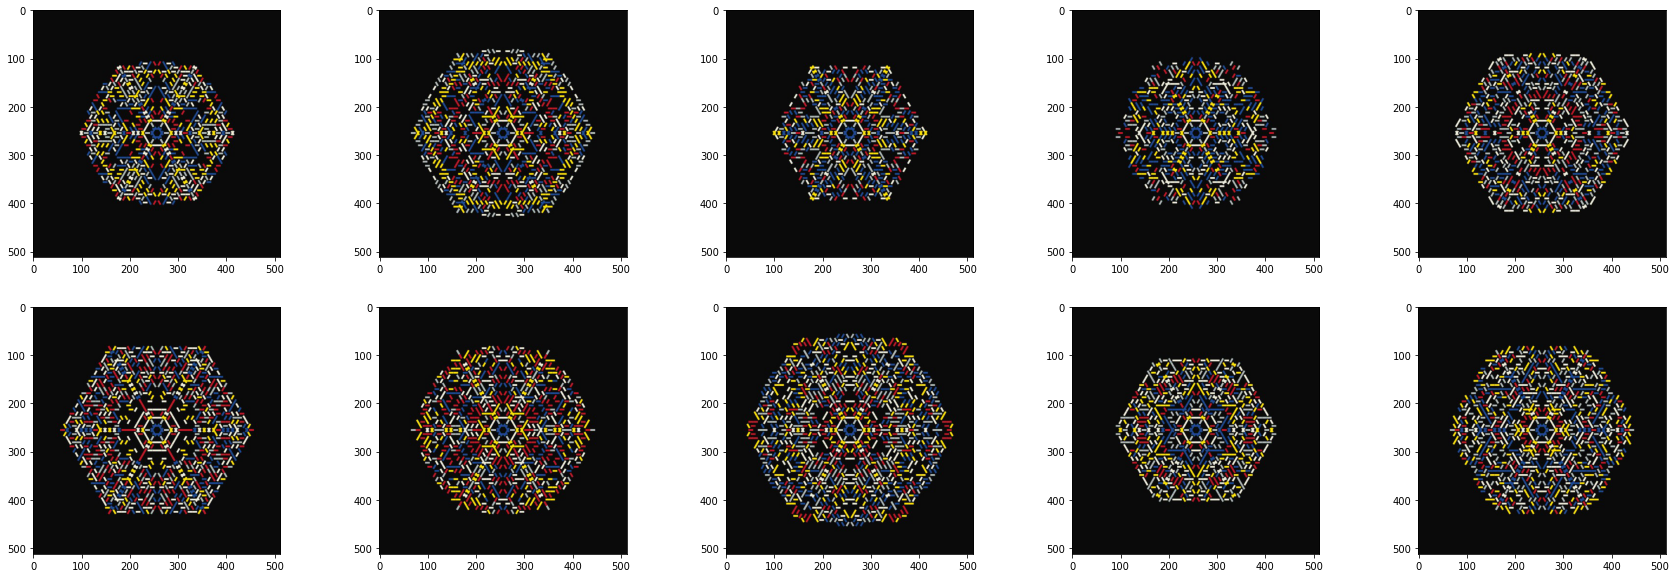

In [8]:
from PIL import Image
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(  metadata.loc[i, 'image'])
    ax[i//5, i%5].imshow(img) 
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

images_cache={}
def get_image(pth):
  # print(pth)

  if pth not in images_cache:
    image = load_img(pth, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    image = img_to_array(image)
    images_cache[pth] = image
  
  return images_cache[pth]
  

img = get_image(metadata.image[1])

In [10]:
len(labels)

499

In [11]:
_dataset = list(zip(metadata.image.values, labels ))

test_dataset=_dataset[0:100]
train_dataset=_dataset[100:]

print(len(_dataset))
print(len(test_dataset))
print(len(train_dataset))



499
100
399


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


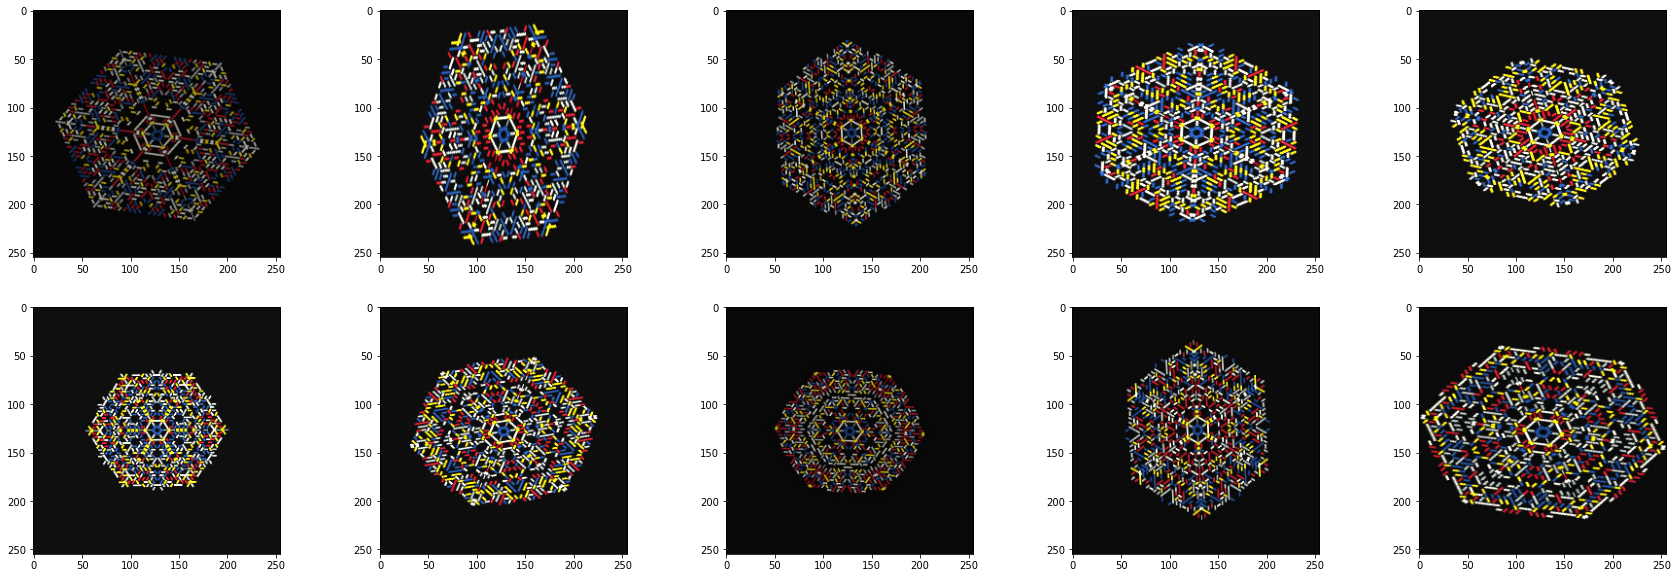

In [12]:


datagen = ImageDataGenerator(
    # rescale= 1./255.,    
    rotation_range=120, 
    zoom_range=0.3, 
    zca_whitening=True,
    shear_range=0.2, 
    brightness_range=[0.7,1.7]
    )

 

def get_generator( batch_size, _dataset):
  while True:
    # Select files (paths/indices) for the batch
    idx = np.random.randint(len(_dataset), size=batch_size)

    batch_input = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in idx:
      pair = _dataset[i]
      img = get_image(pair[0] )
      img =  datagen.random_transform(img)/255.
      label =  pair[1]      

      batch_input.append(img)
      batch_output.append(label)
 
    batch_x = np.array(batch_input)
    batch_y = np.array(batch_output)

    yield (batch_x, batch_y)

BATCH_SIZE=32
 
train_gen = get_generator(BATCH_SIZE, train_dataset );
test_gen = get_generator(BATCH_SIZE, test_dataset );
 
for k in range(1):
  # Plot the data 
  f, ax = plt.subplots(2,5, figsize=(30,10))

  images, _ = next(train_gen)
 
  for i in range(10):
    img = images[i]  
    ax[i//5, i%5].imshow(img ) 
  plt.show()

In [13]:
print(len(_dataset))
np.random.randint(len(train_dataset), size=32)

499


array([374, 124, 119,  33, 183,  91,  98, 204, 166, 150,  60,  65, 141,
       120,  14, 187, 149, 323,   5, 121, 379, 286, 289, 100, 223, 359,
       104, 379, 293, 293,  93, 227])

# The model

### Simples possible baseline model

In [15]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Reshape, Softmax, Conv2D, MaxPooling2D
from keras import Model
from keras import backend as K

input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

  
inputs = Input(name='the_input', shape=input_shape, dtype='float32')

x = inputs
x = Dropout(0.5)(x)
x = Conv2D(6, kernel_size=(8, 8), activation='relu', input_shape=input_shape )(x)
x = MaxPooling2D(pool_size=(6, 6)) (x)
x = Flatten()(x)  
x = Dense(MAX_DIGITS, activation='sigmoid', name='out_dense')(x)

model = Model(inputs=inputs, outputs=x)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 255, 255, 3)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 6)       1158      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 6)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10086)             0         
_________________________________________________________________
out_dense (Dense)            (None, 128)               1291136   
Total params: 1,292,294
Trainable params: 1,292,294
Non-trainable params: 0
_________________________________________________

In [0]:
# BATCH_SIZE
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=200, 
                    validation_data=test_gen,
                    validation_steps=3,
                    epochs=15,                           
                 
                    callbacks = [es],              
                    verbose=1)

### efficientnet-based model

In [0]:
!pip install -U efficientnet

### Building graph on top of Efficientnet

In [92]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Reshape, Softmax, Conv2D, MaxPooling2D
from keras import Model
from keras import backend as K

import efficientnet.keras as efn 

USE_EN = False

if K.image_data_format() == 'channels_first':
    input_shape = (3, IMAGE_SIZE[0], IMAGE_SIZE[1])
else:
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)



if USE_EN:
  base_model = efn.EfficientNetB4(weights='noisy-student', include_top=False)
  x = base_model.output
  inputs=base_model.input

else:
  # x = Input((None, None, 3))
  x = Input(name='the_input', shape=input_shape, dtype='float32')
  inputs = x
  x = Conv2D(6, kernel_size=(8, 8), activation='relu', input_shape=(256, 256, 3))(x)
  x = MaxPooling2D(pool_size=(6, 6)) (x)
  # x = Conv2D(2, kernel_size=(3, 3), activation='relu')(x)
  # x = MaxPooling2D(pool_size=(2, 2)) (x)
  # x = Conv2D(2, kernel_size=(3, 3), activation='relu')(x)
  # x = MaxPooling2D(pool_size=(2, 2)) (x)
  x = Flatten()(x)  

x = Dropout(0.5)(x)
# x = Reshape(target_shape=(128*128, -1), name='reshaping')(x)
 
# x = GlobalAveragePooling2D()(x)  
# x = Flatten()(x)  
# x = Dense(128, activation='relu')(x)

x = Dense(MAX_DIGITS, activation='sigmoid', name='out_dense')(x)
# x = Reshape( (BASE, MAX_DIGITS) ) (x)
# x = Softmax(axis=-2) (x)

model = Model(inputs=inputs, outputs=x)

# fix the feature extraction part of the model
if USE_EN:
  for layer in base_model.layers:
    layer.trainable = True
 

# model.compile(optimizer='Nadam', loss=mse_on_integers, metrics=['categorical_accuracy'])
# model.compile(optimizer='Nadam', loss='mean_squared_error', metrics=['categorical_accuracy'])
# model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 248, 248, 6)       1158      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 41, 41, 6)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 10086)             0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 10086)             0         
_________________________________________________________________
out_dense (Dense)            (None, 128)               1291136   
Total params: 1,292,294
Trainable params: 1,292,294
Non-trainable params: 0
________________________________________________

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=200, 
                    validation_data=test_gen,
                    validation_steps=3,
                    epochs=15,                           
                 
                    callbacks = [es],              
                    verbose=1)

# Analyse (predict) single augmented iname


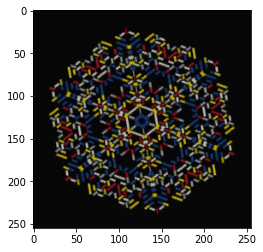

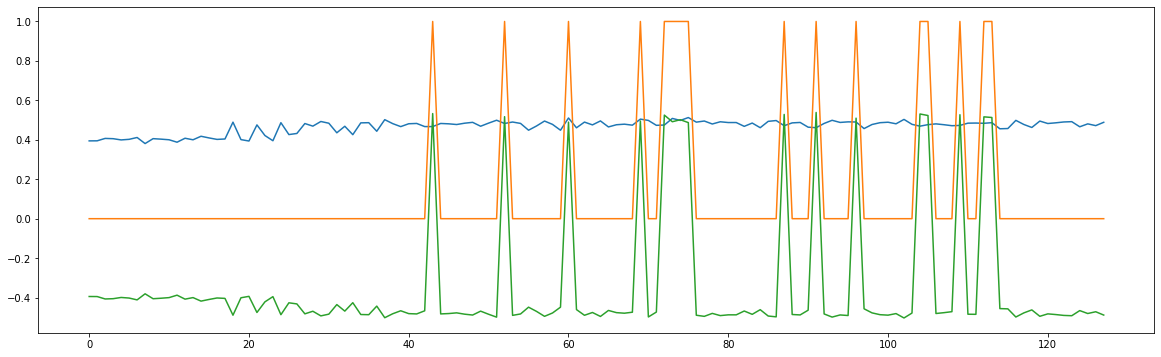

In [19]:
# SAMPLE_INDEX=12

# # _digits = metadata['encoded6'][SAMPLE_INDEX]
# # label_mtx = digits2matrix(_digits)


# img = get_image(metadata.image[SAMPLE_INDEX])
# img =  datagen.random_transform(img)/255.
# plt.imshow(img) 

SAMPLE_INDEX=12

# _digits = metadata['encoded6'][SAMPLE_INDEX]
# label_mtx = digits2matrix(_digits)

pt = _dataset[SAMPLE_INDEX]
img = get_image(pt[0])
img =  datagen.random_transform(img)/255.
plt.imshow(img)


p=model.predict( np.array([img]) )[0]
# print(sum(p.T[0])) #verify column sum is 1.
 
# fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(18, 7))
 
# sns.heatmap(p, cmap="rocket", ax=ax1 )  
# sns.heatmap(label_mtx, cmap="rocket",  ax=ax2 )
 
# plt.show()
plt.figure(figsize=(20,6))
plt.plot(p)
plt.plot(pt[1])

#print ( custom_divergence (p,pt[1] ) )
plt.plot(pt[1]-p)

In [0]:
p=model.predict( np.array([img]) )[0]
print(sum(p.T[0])) #verify column sum is 1.
 
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(18, 7))
 
sns.heatmap(p, cmap="rocket", ax=ax1 )  
sns.heatmap(label_mtx, cmap="rocket",  ax=ax2 )
 
plt.show()

# decoding base6 encoded data

In [0]:
def restore_data(base6_encoded_string):
  a = int(base6_encoded_string, 6)
  b = a.to_bytes(128, byteorder='big')
  return b.decode("utf-8").replace('\x00','')



#-----------------TEST
if False:
  img = get_image(metadata.image[1])
  img =  datagen.random_transform(img)/255.
  p = model.predict( np.array([img, img]) )
  p[0]*5
  pc = [ int(round(v)) for v in p[0]*5 ]
  print(''.join(pc))
  print(metadata['encoded6'][1])


restore_data('431314044000115030505552302251520533005520512545202255454151215111544352332225525313414045113521001312220225')